<a href="https://colab.research.google.com/github/saalimon/qosf-2/blob/master/qosf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install qiskit

     |████████████████████████████████| 8.5MB 5.6MB/s 
     |████████████████████████████████| 17.6MB 231kB/s 
     |████████████████████████████████| 204kB 48.6MB/s 
     |████████████████████████████████| 204kB 43.1MB/s 
     |████████████████████████████████| 2.1MB 40.0MB/s 
     |████████████████████████████████| 1.3MB 36.2MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 5.9MB 33.7MB/s 
     |████████████████████████████████| 194kB 34.6MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 583kB 38.4MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 3.2MB 42.6MB/s 
     |████████████████████████████████| 5.5MB 36.1MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.6-cp36-none-any.whl size=2883 sha256=55e1360c7fa2520eb06264b7d698a0b9abd40b15af90b28e931df841e6f950ee
  Stored in directory: /root/.cache/pip/wheels/b1/5e/2a/a9afb84cb4e8a08

In [11]:
!pip install qiskit[visualization]

     |████████████████████████████████| 163kB 4.8MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.8-cp36-none-any.whl size=131377 sha256=965eef8ada89cc366b2fca1c55b8dd1c1525064339b4ba0df3ceea86d15b779a
  Stored in directory: /root/.cache/pip/wheels/88/23/90/4cf49f59c1eb67af40a2b3a580536bb5f91d40bc0d4cc8e035
Successfully built pylatexenc


# task 4

In [137]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer, BasicAer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal
from qiskit.visualization import plot_histogram

from scipy.optimize import fmin_cobyla

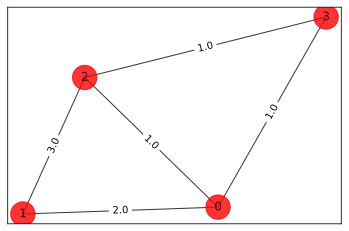

In [105]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,2.0),(0,2,1.0),(0,3,1.0),(1,2,3.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

## baseline result from https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html

In [106]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 2. 1. 1.]
 [2. 0. 3. 0.]
 [1. 3. 0. 1.]
 [1. 0. 1. 0.]]


In [107]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -4.0
Ising Hamiltonian:
IIZZ	(1+0j)
IZIZ	(0.5+0j)
IZZI	(1.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



In [108]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [133]:
qubitOp.to_dict()

{'paulis': [{'coeff': {'imag': 0.0, 'real': 1.0}, 'label': 'IIZZ'},
  {'coeff': {'imag': 0.0, 'real': 0.5}, 'label': 'IZIZ'},
  {'coeff': {'imag': 0.0, 'real': 1.5}, 'label': 'IZZI'},
  {'coeff': {'imag': 0.0, 'real': 0.5}, 'label': 'ZIIZ'},
  {'coeff': {'imag': 0.0, 'real': 0.5}, 'label': 'ZZII'}]}

energy: -1.476438988282498
time: 0.2688484191894531
max-cut objective: -5.4764389882824975
solution: [0. 1. 0. 1.]
solution objective: 7.0


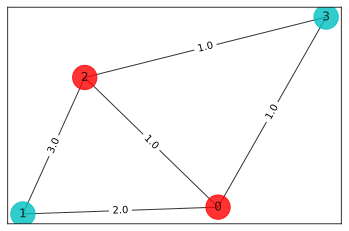

In [109]:
# construct QAOA
cobyla = COBYLA()
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
qaoa = QAOA(qubitOp, cobyla, quantum_instance=quantum_instance)

# run QAOA
result = qaoa.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [110]:
qaoa.get_optimal_circuit().draw()

┌───┐                         ┌───┐┌─────────────┐              ┌───┐»
q_0: ┤ H ├─────────────────────────┤ X ├┤ RZ(0.32947) ├──────────────┤ X ├»
     ├───┤                         └─┬─┘└────┬───┬────┘┌────────────┐└─┬─┘»
q_1: ┤ H ├───────────────────────────┼───────┤ X ├─────┤ RZ(0.9884) ├──┼──»
     ├───┤┌───┐┌─────────────┐┌───┐  │       └─┬─┘     └────────────┘  │  »
q_2: ┤ H ├┤ X ├┤ RZ(0.32947) ├┤ X ├──┼─────────■───────────────────────┼──»
     ├───┤└─┬─┘└─────────────┘└─┬─┘  │                                 │  »
q_3: ┤ H ├──■───────────────────■────■─────────────────────────────────■──»
     └───┘                                                                »
«                    ┌───┐┌─────────────┐┌───┐     ┌───┐     ┌─────────────┐»
«q_0: ───────────────┤ X ├┤ RZ(0.32947) ├┤ X ├─────┤ X ├─────┤ RZ(0.65893) ├»
«          ┌───┐     └─┬─┘└─────────────┘└─┬─┘     └─┬─┘     └─────────────┘»
«q_1: ─────┤ X ├───────┼───────────────────┼─────────■──────────────────────»
«          └─┬─┘       │                   │  ┌─────────────┐               »
«q_2: ───────■─────────■───────────────────■──┤ RX(-3.8134) ├───────────────»
«     ┌─────────────┐                         └─────────────┘               »
«q_3: ┤ RX(-3.8134) ├───────────────────────────────────────────────────────»
«     └─────────────┘                                                       »
«     ┌───┐┌─────────────┐
«q_0: ┤ X ├┤ RX(-3.8134) ├
«     └─┬─┘├─────────────┤
«q_1: ──■──┤ RX(-3.8134) ├
«          └─────────────┘
«q_2: ────────────────────
«                         
«q_3: ────────────────────
«

## example code from https://qiskit.org/textbook/ch-applications/qaoa.html

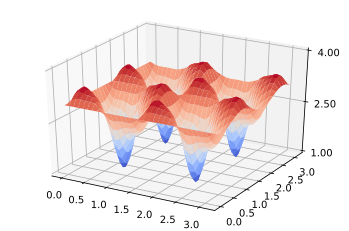


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [111]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

In [112]:
qaoa.get_optimal_circuit().draw()

┌───┐                         ┌───┐┌─────────────┐              ┌───┐»
q_0: ┤ H ├─────────────────────────┤ X ├┤ RZ(0.32947) ├──────────────┤ X ├»
     ├───┤                         └─┬─┘└────┬───┬────┘┌────────────┐└─┬─┘»
q_1: ┤ H ├───────────────────────────┼───────┤ X ├─────┤ RZ(0.9884) ├──┼──»
     ├───┤┌───┐┌─────────────┐┌───┐  │       └─┬─┘     └────────────┘  │  »
q_2: ┤ H ├┤ X ├┤ RZ(0.32947) ├┤ X ├──┼─────────■───────────────────────┼──»
     ├───┤└─┬─┘└─────────────┘└─┬─┘  │                                 │  »
q_3: ┤ H ├──■───────────────────■────■─────────────────────────────────■──»
     └───┘                                                                »
«                    ┌───┐┌─────────────┐┌───┐     ┌───┐     ┌─────────────┐»
«q_0: ───────────────┤ X ├┤ RZ(0.32947) ├┤ X ├─────┤ X ├─────┤ RZ(0.65893) ├»
«          ┌───┐     └─┬─┘└─────────────┘└─┬─┘     └─┬─┘     └─────────────┘»
«q_1: ─────┤ X ├───────┼───────────────────┼─────────■──────────────────────»
«          └─┬─┘       │                   │  ┌─────────────┐               »
«q_2: ───────■─────────■───────────────────■──┤ RX(-3.8134) ├───────────────»
«     ┌─────────────┐                         └─────────────┘               »
«q_3: ┤ RX(-3.8134) ├───────────────────────────────────────────────────────»
«     └─────────────┘                                                       »
«     ┌───┐┌─────────────┐
«q_0: ┤ X ├┤ RX(-3.8134) ├
«     └─┬─┘├─────────────┤
«q_1: ──■──┤ RX(-3.8134) ├
«          └─────────────┘
«q_2: ────────────────────
«                         
«q_3: ────────────────────
«

In [121]:
QAOA_circuit = QuantumCircuit(n, n)
QAOA_circuit.h(range(n))
QAOA_circuit.barrier()
for edge in elist:
  k = edge[0]
  l = edge[1]
  QAOA_circuit.cp(-2*gamma, k, l)
  QAOA_circuit.p(gamma, k)
  QAOA_circuit.p(gamma, l)

QAOA_circuit.barrier()
QAOA_circuit.rx(2*beta, range(n))

QAOA_circuit.barrier()
QAOA_circuit.measure(range(n),range(n))

QAOA_circuit.draw()

┌───┐ ░            ┌────────┐           ┌────────┐            ┌────────┐»
q_0: ┤ H ├─░──────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────■──────┤ P(1.9) ├»
     ├───┤ ░ ┌────┴────┐├────────┤     │     └────────┘     │      └────────┘»
q_1: ┤ H ├─░─┤ P(-3.8) ├┤ P(1.9) ├─────┼────────────────────┼──────────■─────»
     ├───┤ ░ └─────────┘└────────┘┌────┴────┐┌────────┐     │     ┌────┴────┐»
q_2: ┤ H ├─░──────────────────────┤ P(-3.8) ├┤ P(1.9) ├─────┼─────┤ P(-3.8) ├»
     ├───┤ ░                      └─────────┘└────────┘┌────┴────┐└┬────────┤»
q_3: ┤ H ├─░───────────────────────────────────────────┤ P(-3.8) ├─┤ P(1.9) ├»
     └───┘ ░                                           └─────────┘ └────────┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                     ░ ┌─────────┐ ░ ┌─┐         
«q_0: ────────────────────────────────░─┤ RX(0.4) ├─░─┤M├─────────
«     ┌────────┐                      ░ ├─────────┤ ░ └╥┘┌─┐      
«q_1: ┤ P(1.9) ├──────────────────────░─┤ RX(0.4) ├─░──╫─┤M├──────
«     ├────────┤           ┌────────┐ ░ ├─────────┤ ░  ║ └╥┘┌─┐   
«q_2: ┤ P(1.9) ├─────■─────┤ P(1.9) ├─░─┤ RX(0.4) ├─░──╫──╫─┤M├───
«     └────────┘┌────┴────┐├────────┤ ░ ├─────────┤ ░  ║  ║ └╥┘┌─┐
«q_3: ──────────┤ P(-3.8) ├┤ P(1.9) ├─░─┤ RX(0.4) ├─░──╫──╫──╫─┤M├
«               └─────────┘└────────┘ ░ └─────────┘ ░  ║  ║  ║ └╥┘
«c: 4/═════════════════════════════════════════════════╩══╩══╩══╩═
«                                                      0  1  2  3

In [122]:
def cost_function_C(x,G):
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

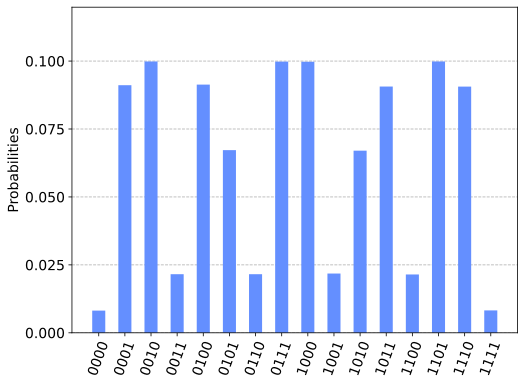

In [123]:
backend      = Aer.get_backend("qasm_simulator")
shots        = 1000000

simulate     = execute(QAOA_circuit, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

In [129]:
QAOA_results.get_counts()
max_key = max(QAOA_results.get_counts(), key=QAOA_results.get_counts().get)
print('cost function of %s is %.02f'% (max_key,cost_function_C([int(num) for num in list(max_key)],G)))

cost function of 1101 is 5.00


## my experiments 

In [144]:
def create_qaoa_circuit(x):
  QAOA_circuit = QuantumCircuit(n, n)
  QAOA_circuit.h(range(n))
  QAOA_circuit.barrier()
  for edge in elist:
    k = edge[0]
    l = edge[1]
    QAOA_circuit.cp(-2*x[0], k, l)
    QAOA_circuit.p(x[0], k)
    QAOA_circuit.p(x[0], l)

  QAOA_circuit.barrier()
  QAOA_circuit.rx(2*x[1], range(n))

  QAOA_circuit.barrier()
  return QAOA_circuit

In [150]:
def run_qaoa(x):
  QAOA_circuit = create_qaoa_circuit(x)
  QAOA_circuit.measure(range(n),range(n))
  backend      = Aer.get_backend("qasm_simulator")
  shots        = 10000

  simulate     = execute(QAOA_circuit, backend=backend, shots=shots)
  QAOA_results = simulate.result()

  plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)
  max_key = max(QAOA_results.get_counts(), key=QAOA_results.get_counts().get)
  # get the opposite side of cost becuase I want to maximize the cost function not miniminze then I use -cost for cost function
  cost = -cost_function_C([int(num) for num in list(max_key)],G)
  print('cost function of %s is %.02f'% (max_key,-cost))
  return cost

In [155]:
cobyla = COBYLA()
res = cobyla.optimize(num_vars=2,objective_function=run_qaoa,initial_point=[gamma,beta])

cost function of 0111 is 4.00
cost function of 0101 is 7.00
cost function of 0100 is 5.00
cost function of 0101 is 7.00
cost function of 0101 is 7.00
cost function of 0110 is 4.00
cost function of 0000 is 0.00
cost function of 1010 is 7.00
cost function of 1101 is 5.00
cost function of 1010 is 7.00
cost function of 1010 is 7.00
cost function of 0101 is 7.00
cost function of 0000 is 0.00
cost function of 1010 is 7.00
cost function of 0101 is 7.00
cost function of 0101 is 7.00
cost function of 1010 is 7.00
cost function of 0010 is 5.00
cost function of 0101 is 7.00
cost function of 1010 is 7.00


In [161]:
QAOA_circuit = create_qaoa_circuit(res[0])
QAOA_circuit.measure(range(n),range(n))
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(QAOA_circuit, backend=backend, shots=shots)
QAOA_results = simulate.result()

In [162]:
max_key = max(QAOA_results.get_counts(), key=QAOA_results.get_counts().get)
print('cost function of %s is %.02f'% (max_key,cost_function_C([int(num) for num in list(max_key)],G)))
QAOA_circuit.draw()

cost function of 0101 is 7.00


┌───┐ ░            ┌────────┐           ┌────────┐            ┌────────┐»
q_0: ┤ H ├─░──────■─────┤ P(2.9) ├─────■─────┤ P(2.9) ├─────■──────┤ P(2.9) ├»
     ├───┤ ░ ┌────┴────┐├────────┤     │     └────────┘     │      └────────┘»
q_1: ┤ H ├─░─┤ P(-5.8) ├┤ P(2.9) ├─────┼────────────────────┼──────────■─────»
     ├───┤ ░ └─────────┘└────────┘┌────┴────┐┌────────┐     │     ┌────┴────┐»
q_2: ┤ H ├─░──────────────────────┤ P(-5.8) ├┤ P(2.9) ├─────┼─────┤ P(-5.8) ├»
     ├───┤ ░                      └─────────┘└────────┘┌────┴────┐└┬────────┤»
q_3: ┤ H ├─░───────────────────────────────────────────┤ P(-5.8) ├─┤ P(2.9) ├»
     └───┘ ░                                           └─────────┘ └────────┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                     ░ ┌─────────┐ ░ ┌─┐         
«q_0: ────────────────────────────────░─┤ RX(0.4) ├─░─┤M├─────────
«     ┌────────┐                      ░ ├─────────┤ ░ └╥┘┌─┐      
«q_1: ┤ P(2.9) ├──────────────────────░─┤ RX(0.4) ├─░──╫─┤M├──────
«     ├────────┤           ┌────────┐ ░ ├─────────┤ ░  ║ └╥┘┌─┐   
«q_2: ┤ P(2.9) ├─────■─────┤ P(2.9) ├─░─┤ RX(0.4) ├─░──╫──╫─┤M├───
«     └────────┘┌────┴────┐├────────┤ ░ ├─────────┤ ░  ║  ║ └╥┘┌─┐
«q_3: ──────────┤ P(-5.8) ├┤ P(2.9) ├─░─┤ RX(0.4) ├─░──╫──╫──╫─┤M├
«               └─────────┘└────────┘ ░ └─────────┘ ░  ║  ║  ║ └╥┘
«c: 4/═════════════════════════════════════════════════╩══╩══╩══╩═
«                                                      0  1  2  3

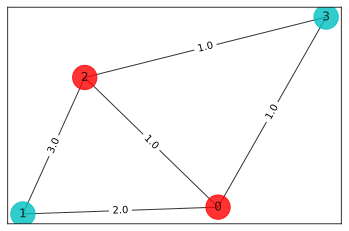

In [163]:
colors = ['r' if int(max_key[i]) == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)